In [1]:
%pip install -qU langgraph langchain-openai

Note: you may need to restart the kernel to use updated packages.


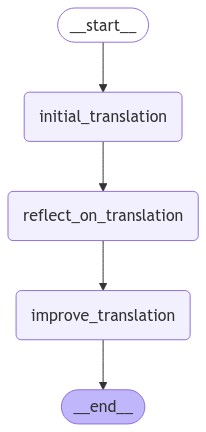

================================ Human Message =================================

静夜思\n
床前明月光，疑是地上霜。\n
举头望明月，低头思故乡。\n
================================== Ai Message ==================================

Quiet Night Thoughts  
The bright moonlight before my bed, I suspect it’s frost on the ground.  
I raise my head to gaze at the bright moon, and lower it to think of my hometown.
================================== Ai Message ==================================

1. **Title Translation**: Change “Quiet Night Thoughts” to “Thoughts on a Quiet Night” to better reflect the original meaning and maintain a more natural flow in English.

2. **Line Breaks**: Consider formatting the translation to reflect the line breaks of the original poem, as this is a significant aspect of its structure and rhythm. For example:
   ```
   The bright moonlight before my bed,  
   I suspect it’s frost on the ground.  
   I raise my head to gaze at the bright moon,  
   and lower it to think of my hometown.
   ```

3

In [1]:
from typing import TypedDict, Annotated
from langchain_openai import ChatOpenAI
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from getpass import getpass
import os

key=getpass()

# ++ lang smith
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = key
os.environ["LANGCHAIN_PROJECT"] = "default"

key=getpass()

llm = ChatOpenAI(
    model="gpt-4o-mini",
    api_key=key,
    base_url="https://api.apiyi.com/v1"
)
source_lang = "Chinese"
target_lang = "English"


# state in pydantic 
class State(TypedDict):
    messages: Annotated[list, add_messages]

def initial_translation(state: State):
    # src txt is msg in state
    source_text = state["messages"][-1].content
    system_prompt = f"You are an expert linguist, specializing in translation from {source_lang} to {target_lang}."
    translation_prompt = f"""This is an {source_lang} to {target_lang} translation, please provide the {target_lang} translation for this text. \
    Do not provide any explanations or text apart from the translation.
    {source_lang}: {source_text}

    {target_lang}:"""

    messages = [
        (
            "system",
            system_prompt,
        ),
        ("human", translation_prompt),
    ]
    return {"messages": [llm.invoke(messages)]}

def reflect_on_translation(state: State):
    country = "America"
    # user input
    source_text = state["messages"][-2].content
    # assistant resp
    translation_1 = state["messages"][-1].content
    system_message = f"You are an expert linguist specializing in translation from {source_lang} to {target_lang}. \
You will be provided with a source text and its translation and your goal is to improve the translation."
    
    reflection_prompt = f"""Your task is to carefully read a source text and a translation from {source_lang} to {target_lang}, and then give constructive criticism and helpful suggestions to improve the translation. \
    The final style and tone of the translation should match the style of {target_lang} colloquially spoken in {country}.

    The source text and initial translation, delimited by XML tags <SOURCE_TEXT></SOURCE_TEXT> and <TRANSLATION></TRANSLATION>, are as follows:

    <SOURCE_TEXT>
    {source_text}
    </SOURCE_TEXT>

    <TRANSLATION>
    {translation_1}
    </TRANSLATION>

    When writing suggestions, pay attention to whether there are ways to improve the translation's \n\
    (i) accuracy (by correcting errors of addition, mistranslation, omission, or untranslated text),\n\
    (ii) fluency (by applying {target_lang} grammar, spelling and punctuation rules, and ensuring there are no unnecessary repetitions),\n\
    (iii) style (by ensuring the translations reflect the style of the source text and take into account any cultural context),\n\
    (iv) terminology (by ensuring terminology use is consistent and reflects the source text domain; and by only ensuring you use equivalent idioms {target_lang}).\n\

    Write a list of specific, helpful and constructive suggestions for improving the translation.
    Each suggestion should address one specific part of the translation.
    Output only the suggestions and nothing else."""
        
    messages = [
        (
            "system",
            system_message,
        ),
        ("human", reflection_prompt),
    ]
    return {"messages": [llm.invoke(messages)]}


def improve_translation(state: State):
    # user input
    source_text = state["messages"][-3].content
    # init trans
    translation_1 = state["messages"][-2].content
    # improvement
    reflection = state["messages"][-1].content

    system_message = f"You are an expert linguist, specializing in translation editing from {source_lang} to {target_lang}."

    improve_prompt = f"""Your task is to carefully read, then edit, a translation from {source_lang} to {target_lang}, taking into
    account a list of expert suggestions and constructive criticisms.

    The source text, the initial translation, and the expert linguist suggestions are delimited by XML tags <SOURCE_TEXT></SOURCE_TEXT>, <TRANSLATION></TRANSLATION> and <EXPERT_SUGGESTIONS></EXPERT_SUGGESTIONS> \
    as follows:

    <SOURCE_TEXT>
    {source_text}
    </SOURCE_TEXT>

    <TRANSLATION>
    {translation_1}
    </TRANSLATION>

    <EXPERT_SUGGESTIONS>
    {reflection}
    </EXPERT_SUGGESTIONS>

    Please take into account the expert suggestions when editing the translation. Edit the translation by ensuring:

    (i) accuracy (by correcting errors of addition, mistranslation, omission, or untranslated text),
    (ii) fluency (by applying {target_lang} grammar, spelling and punctuation rules and ensuring there are no unnecessary repetitions), \
    (iii) style (by ensuring the translations reflect the style of the source text)
    (iv) terminology (inappropriate for context, inconsistent use), or
    (v) other errors.

    Output only the new translation and nothing else."""

    messages = [
        (
            "system",
            system_message,
        ),
        ("human", improve_prompt),
    ]
    return {"messages": [llm.invoke(messages)]}

# init graph & add nodes
workflow = StateGraph(State)
workflow.add_node("initial_translation", initial_translation)
workflow.add_node("reflect_on_translation", reflect_on_translation)
workflow.add_node("improve_translation", improve_translation)

# define graph
workflow.set_entry_point("initial_translation")
workflow.add_edge("initial_translation", "reflect_on_translation")
workflow.add_edge("reflect_on_translation", "improve_translation")
workflow.add_edge("improve_translation", END)
#workflow.add_edge("chat", "__end__")
#workflow.set_finish_point("chat")
graph = workflow.compile()

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

"""
静夜思\n
床前明月光，疑是地上霜。\n
举头望明月，低头思故乡。\n
"""

user_input = input("Please input the text needs translation (CN → EN): ")
events = graph.stream(
    {"messages": [("user", user_input)]}, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()


# for event in graph.stream({"messages": ("user", user_input)}):
#     for value in event.values():
#         print("Assistant:", value["messages"][-1].content)